<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/microclimate_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install/upgrade the packages we need
!pip -q install pandas numpy requests "tensorflow==2.20.0" "keras==3.11.3" scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 763.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.0 MB/s eta 0:00:00


In [2]:
# import all the packages that we need
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
from keras import layers
keras.utils.set_random_seed(42) # set seed to ensure reproducibility
from keras import ops
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Callable, Dict, Iterable, Union, Any
import time
import tensorflow as tf
import math
import pandas as pd
import requests
import json
from datetime import datetime,timedelta,timezone,date
from typing import Dict, Any,  Tuple
from sklearn.preprocessing import StandardScaler
from __future__ import annotations

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
def fetch_couva_weather_data(
    latitude: float = 10.44,
    longitude: float = -61.44,
    total_days: int = 365,
    safety_lag_days: int = 5
) -> pd.DataFrame:
    """
    Fetch hourly weather data for Couva, Trinidad from open-meteo.com.

    Args:
        latitude: Geographic latitude of Couva in decimal degrees.
        longitude: Geographic longitude of Couva in decimal degrees.
        total_days: Number of days of historical data to retrieve.
        safety_lag_days: Buffer days to ensure only finalized historical data.

    Returns:
        A DataFrame indexed by local datetime with columns:
        ['temperature', 'humidity', 'pressure', 'wind_speed', 'precipitation'].
    """
    end_date: date = datetime.utcnow().date() - timedelta(days=safety_lag_days)
    start_date: date = end_date - timedelta(days=total_days)

    api_base_url: str = "https://archive-api.open-meteo.com/v1/era5"
    query_parameters: Dict[str, Any] = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date.isoformat(),
        "end_date": end_date.isoformat(),
        "hourly": ",".join([
            "temperature_2m",
            "relative_humidity_2m",
            "surface_pressure",
            "wind_speed_10m",
            "precipitation"
        ]),
        "timezone": "America/Port_of_Spain"
    }

    response = requests.get(api_base_url, params=query_parameters, timeout=60)
    response.raise_for_status()
    weather_json: Dict[str, Any] = response.json()

    datetimes_local = pd.to_datetime(weather_json["hourly"]["time"])
    weather_dataframe = pd.DataFrame({
        "temperature": weather_json["hourly"]["temperature_2m"],
        "humidity": weather_json["hourly"]["relative_humidity_2m"],
        "pressure": weather_json["hourly"]["surface_pressure"],
        "wind_speed": weather_json["hourly"]["wind_speed_10m"],
        "precipitation": weather_json["hourly"]["precipitation"],
    }, index=datetimes_local)

    # Ensure chronological order and fill tiny gaps
    weather_dataframe = weather_dataframe.sort_index().interpolate(limit_direction="both")

    return weather_dataframe

# Call the function to actually fetch the data
couva_weather_dataframe: pd.DataFrame = fetch_couva_weather_data()
# print a quick summary
print(couva_weather_dataframe.head(), couva_weather_dataframe.tail(), couva_weather_dataframe.shape)


/tmp/ipython-input-4277003254.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date: date = datetime.utcnow().date() - timedelta(days=safety_lag_days)


                     temperature  humidity  pressure  wind_speed  \
2024-10-17 00:00:00         25.8        83    1010.5         7.3   
2024-10-17 01:00:00         25.4        85    1009.6         7.1   
2024-10-17 02:00:00         25.2        85    1008.9         6.6   
2024-10-17 03:00:00         25.2        86    1008.6         5.3   
2024-10-17 04:00:00         24.9        88    1008.6         3.5   

                     precipitation  
2024-10-17 00:00:00            0.0  
2024-10-17 01:00:00            0.0  
2024-10-17 02:00:00            0.0  
2024-10-17 03:00:00            0.0  
2024-10-17 04:00:00            0.0                        temperature  humidity  pressure  wind_speed  \
2025-10-17 19:00:00         27.6        79    1008.5        15.2   
2025-10-17 20:00:00         27.7        79    1009.2        13.9   
2025-10-17 21:00:00         27.7        78    1009.8        15.6   
2025-10-17 22:00:00         27.2        78    1010.1        14.4   
2025-10-17 23:00:00         2

In [4]:
def create_sliding_windows(
    feature_matrix: np.ndarray,
    target_array: np.ndarray,
    window_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequential sliding windows for supervised learning on time-series data.

    Args:
        feature_matrix: 2-D NumPy array [num_samples, num_features]
                        containing the input features (already normalized).
        target_array:   1-D NumPy array [num_samples] containing target values
                        (for our case, next-hour temperature).
        window_size:    Number of time steps (hours) to include per input sample.

    Returns:
        Tuple of:
          X_windows: 3-D array [num_sequences, window_size, num_features]
          y_targets: 1-D array [num_sequences] matching each input window
    """

    sequential_features: list[np.ndarray] = []  # stores each sliding window of features
    sequential_targets: list[float] = []        # stores the target value for each window

    # iterate over all possible start indices that produce a full window
    for start_index in range(len(feature_matrix) - window_size + 1):
        end_index = start_index + window_size  # end of this window

        # slice the historical portion of the data (past `window_size` hours)
        current_window: np.ndarray = feature_matrix[start_index:end_index, :]
        sequential_features.append(current_window)

        # the label is the target value *at the end* of this window
        current_target: float = target_array[end_index - 1]
        sequential_targets.append(current_target)

    # convert lists to NumPy arrays for training
    return (
        np.array(sequential_features, dtype=np.float32),
        np.array(sequential_targets, dtype=np.float32)
    )


# ---------------------------------------------------------------------
# CONFIGURATION: define how far back we look and how far ahead we predict
# ---------------------------------------------------------------------

historical_window_hours: int = 72   # number of past hours to use as input
forecast_horizon_hours: int = 1     # predict the temperature 1 hour into the future


# ---------------------------------------------------------------------
# ALIGN FEATURES AND TARGETS
# ---------------------------------------------------------------------

# Shift the temperature column forward by `forecast_horizon_hours`
# so each row’s target corresponds to a future reading.
target_series: pd.Series = couva_weather_dataframe["temperature"].shift(-forecast_horizon_hours)

# Combine features and shifted target into a single aligned DataFrame,
# then drop any NaN values caused by the shift.
combined_dataframe: pd.DataFrame = pd.concat(
    [couva_weather_dataframe, target_series.rename("target_temperature")],
    axis=1
).dropna()


# ---------------------------------------------------------------------
# NORMALIZE (STANDARDIZE) FEATURES
# ---------------------------------------------------------------------

# ML models converge faster when our inputs have zero mean and unit variance.
# We fit the scaler on *all* features (not including the target/y) and transform them.
standard_scaler: StandardScaler = StandardScaler()
normalized_features: np.ndarray = standard_scaler.fit_transform(
    combined_dataframe.drop(columns=["target_temperature"])
)

# Extract target values as a NumPy array of float32 (to match TensorFlow’s dtype).
target_values: np.ndarray = combined_dataframe["target_temperature"].to_numpy(dtype=np.float32)


# ---------------------------------------------------------------------
# BUILD SUPERVISED LEARNING WINDOWS
# ---------------------------------------------------------------------

# Convert the continuous time series into overlapping sequences.
input_sequences, target_sequences = create_sliding_windows(
    feature_matrix=normalized_features,
    target_array=target_values,
    window_size=historical_window_hours
)


# ---------------------------------------------------------------------
# SPLIT DATASET CHRONOLOGICALLY
# ---------------------------------------------------------------------

# We never shuffle time-series data, because order matters.
# Instead, we split it into train/validation/test segments by time.
num_total_samples: int = len(input_sequences)
num_train_samples: int = int(0.70 * num_total_samples) # take 70% for training
num_validation_samples: int = int(0.85 * num_total_samples)  # then 15% for validation and the remaining 15 % for test

# Perform the splits
X_train: np.ndarray = input_sequences[:num_train_samples]
y_train: np.ndarray = target_sequences[:num_train_samples]

X_validate: np.ndarray = input_sequences[num_train_samples:num_validation_samples]
y_validate: np.ndarray = target_sequences[num_train_samples:num_validation_samples]

X_test: np.ndarray = input_sequences[num_validation_samples:]
y_test: np.ndarray = target_sequences[num_validation_samples:]

# Display shapes so we know exactly what each dataset looks like
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validate.shape, y_validate.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (6098, 72, 5) (6098,)
Validation set shape: (1307, 72, 5) (1307,)
Test set shape: (1307, 72, 5) (1307,)


##The image below illustrates how we're using the sliding-window forecasting to predict two example features (temperature and humidity)

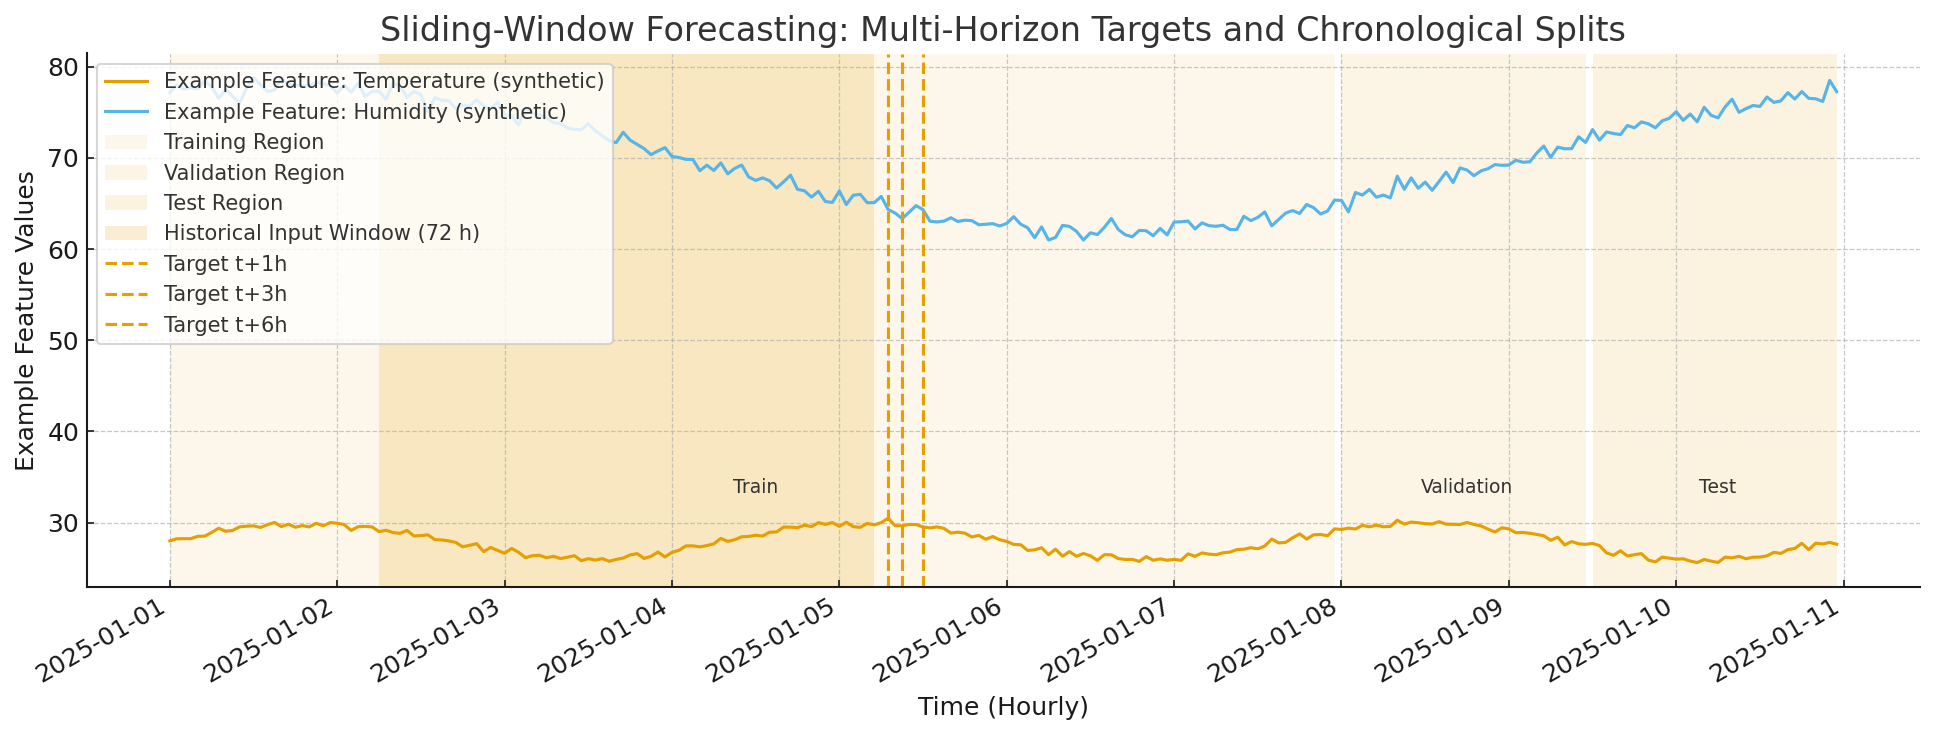

In [6]:
def build_one_dimensional_convolutional_model(
    input_window_length: int,
    number_of_input_features: int,
    dropout_rate: float = 0.10,
    first_block_filters: int = 16,
    second_block_filters: int = 32,
) -> keras.Model:
    """
    We want to build a tiny, clean 1D CNN that predicts next-hour temperature.
    We want something we can actually deploy on a microcontroller:
      - a small parameter count so it fits comfortably,
      - enough temporal receptive field to cover our 72-hour window,
      - layers that behave nicely after INT8 quantization

    Args:
        input_window_length: how many past hours each input sample contains (e.g., 72).
        number_of_input_features: feature count per hour (temp, humidity, pressure, wind, rain = 5).
        dropout_rate: gentle regularization to keep overfitting in check.
        first_block_filters: channels for the first convolutional block.
        second_block_filters: channels for the second (separable) block.

    Returns:
        A compiled Keras regression model that outputs one scalar temperature.
    """

    # Our inputs are [time_steps, features]. Batch dimension appears at runtime.
    input_layer: keras.layers.Input = keras.Input(
        shape=(input_window_length, number_of_input_features),
        name="input_window"
    )

    # ----- Convolutional Block 1 -----
    # First pass: capture short hourly trends with a slightly wider kernel (k=5).
    convolution_1: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=5,
        padding="same",
        activation="relu",
        name="conv1_k5_f16"
    )(input_layer)

    # Second pass: a tighter kernel (k=3) to refine features and add nonlinearity.
    convolution_2: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="conv2_k3_f16"
    )(convolution_1)

    # We downsample the time axis by 2 so the model stays lightweight.
    pooled_features_1: layers.Layer = layers.MaxPooling1D(
        pool_size=2,
        name="maxpool1_stride2"
    )(convolution_2)

    # ----- Convolutional Block 2 (separable = cheaper) -----
    # SeparableConv1D keeps accuracy decent while cutting parameters and MACs.
    separable_convolution: layers.Layer = layers.SeparableConv1D(
        filters=second_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="sepconv_k3_f32"
    )(pooled_features_1)

    # Instead of Flatten + Dense (parameter heavy), we average across time.
    global_temporal_aggregate: layers.Layer = layers.GlobalAveragePooling1D(
        name="global_average_pool"
    )(separable_convolution)

    # A touch of dropout for stability; small rate so we do not underfit.
    regularized_features: layers.Layer = layers.Dropout(
        rate=dropout_rate,
        name="dropout_regularization"
    )(global_temporal_aggregate)

    # Final linear head: give us one float, the next-hour temperature.
    output_temperature: layers.Layer = layers.Dense(
        units=1,
        dtype="float32",  # keep outputs in float32; avoids accidental dtype promotions downstream
        name="predicted_temperature"
    )(regularized_features)

    # Wire up the graph.
    model: keras.Model = keras.Model(
        inputs=input_layer,
        outputs=output_temperature,
        name="lightweight_1d_cnn_forecaster"
    )

    # Defaults that work: Adam + MSE for training, MAE for easy-to-read error in °C.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )

    return model


# -----------------------------
# Build the model
# -----------------------------
# Pull the shapes straight from our Step-2 tensors so everything lines up.
input_window_length: int = X_train.shape[1]
number_of_input_features: int = X_train.shape[2]

weather_forecasting_model: keras.Model = build_one_dimensional_convolutional_model(
    input_window_length=input_window_length,
    number_of_input_features=number_of_input_features,
    dropout_rate=0.10,
    first_block_filters=16,
    second_block_filters=32
)

# Quick sanity check on layers, output shapes, and parameter counts.
weather_forecasting_model.summary()


# -----------------------------
# Callbacks we use
# -----------------------------
# 1) Save the best validation state so we don’t lose it to late-epoch noise.
model_checkpoint_callback: keras.callbacks.ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_weather_forecasting_model.keras",
    monitor="val_mae",   # we care about °C error on validation
    mode="min",
    save_best_only=True,
    verbose=1
)

# 2) Stop when validation stops improving, and roll back to the best weights.
early_stopping_callback: keras.callbacks.EarlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_mae",
    mode="min",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 3) If progress stalls, shrink the learning rate and try smaller steps.
reduce_lr_on_plateau_callback: keras.callbacks.ReduceLROnPlateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)


# -----------------------------
# Train
# -----------------------------
# Moderate batch size keeps training steady in Colab.
# We always pass validation data so the callbacks have something real to watch.
training_history: keras.callbacks.History = weather_forecasting_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_validate, y_validate),
    epochs=100,
    batch_size=64,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_on_plateau_callback],
    verbose=1
)


# -----------------------------
# Final check on unseen data
# -----------------------------
# We want to know the error we should expect in the wild.
test_loss_value: float
test_mae_value: float
test_loss_value, test_mae_value = weather_forecasting_model.evaluate(
    x=X_test,
    y=y_test,
    verbose=0
)
print(f"Final Test Mean Absolute Error (degrees C): {float(test_mae_value):.3f}")

# We keep the last epoch metrics handy for quick logging/plots.
training_history_dictionary: Dict[str, list[float]] = training_history.history
print({k: round(v[-1], 4) for k, v in training_history_dictionary.items() if len(v) > 0})

Model: "lightweight_1d_cnn_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_window (InputLayer)       │ (None, 72, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_k5_f16 (Conv1D)           │ (None, 72, 16)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_k3_f16 (Conv1D)           │ (None, 72, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_stride2 (MaxPooling1D) │ (None, 36, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sepconv_k3_f32                  │ (None, 36, 32)         │           592 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pool             │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_regularization          │ (None, 32)             │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predicted_temperature (Dense)   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,825 (7.13 KB)

 Trainable params: 1,825 (7.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 695.7127 - mae: 26.2096
Epoch 1: val_mae improved from None to 6.93275, saving model to best_weather_forecasting_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 524.3256 - mae: 21.7229 - val_loss: 65.6217 - val_mae: 6.9327 - learning_rate: 0.0010
Epoch 2/100
88/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.1391 - mae: 4.9350
Epoch 2: val_mae improved from 6.93275 to 4.16874, saving model to best_weather_forecasting_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.9435 - mae: 4.4192 - val_loss: 24.5047 - val_mae: 4.1687 - learning_rate: 0.0010
Epoch 3/100
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.4599 - mae: 3.8538
Epoch 3: val_mae improved from 4.16874 to 3.17167, saving model to best_weather_forecasting_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.3254 - mae: 3.8502 - val_loss: 15.5996 - val_mae: 3.1717 - learning_rate: 0.0010
Epoch 4/100
88/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 